In [ ]:
# Project Name | Facebook AI Hackathon - PyTorch

### Description

### Built With
- **Infrastructure**: [Amazon Web Services SageMaker](https://aws.amazon.com/sagemaker/)
- **Deep Learning Library**: [PyTorch](https://pytorch.org/), transfer learning with pretrained [ResNet18](https://download.pytorch.org/models/resnet18-5c106cde.pth)
- **Training Dataset**: [PlantVillage Disease Classification Challenge - Color Images](https://zenodo.org/record/1204914#.Xk93uBNKjPB)

### Team Members:
- [Samuel James](https://www.linkedin.com/in/samuel-james-abiodun/?originalSubdomain=de)
- [Emmanuel Adigun](https://www.linkedin.com/in/emmanuel-adigun-20202b70/?originalSubdomain=ng)
- [Olalekan Elesin](https://www.linkedin.com/in/elesinolalekan/)


### Challenges:
- Currently, we had access to dataset containing images of leaves. This alone limits the performance of the model as it would not be able to classify the fruits. We hope to collect data on the fruits and improve on the performance of the model.
- Expensive but affordable to train on GPU due to infrastructure cost. This is because GPU even though on the cloud do not come cheap.
- Deployment might also be expensive. However, we hosted the model for free on [Heroku](https://www.heroku.com/). If the project at some point starts generating revenue, we will move to scale the deployment on [AWS SageMaker](https://aws.amazon.com/sagemaker/).

In [1]:
from __future__ import print_function, division

import time
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()
print(torch.backends.cudnn.version())
print(torch.backends.cudnn.enabled == True)
print(torch.cuda.is_available())

7603
True
True


In [2]:
data_dir = 'new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)'

In [3]:
from subprocess import check_output
print(check_output(["ls", data_dir]).decode("utf8"))

train
valid



Data augmentation and normalization for training and just normalization for validation

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}

In [6]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'valid']}

In [7]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [174]:
# image plot for Tensor
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


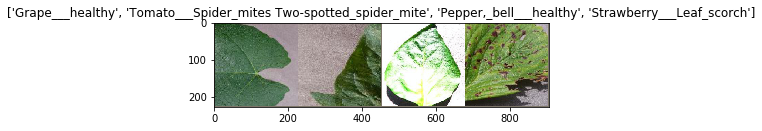

In [11]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [175]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """
    Model Training function
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [14]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 79.8MB/s]


In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=4)

Epoch 0/3
----------
train Loss: 0.6902 Acc: 0.7993
valid Loss: 0.1562 Acc: 0.9599

Epoch 1/3
----------
train Loss: 0.3822 Acc: 0.8869
valid Loss: 0.1105 Acc: 0.9667

Epoch 2/3
----------
train Loss: 0.2999 Acc: 0.9109
valid Loss: 0.1113 Acc: 0.9685

Epoch 3/3
----------
train Loss: 0.2465 Acc: 0.9251
valid Loss: 0.1386 Acc: 0.9694

Training complete in 70m 44s
Best val Acc: 0.969440


## Manual Model Evaluation

In [18]:
from pathlib import Path
from PIL import Image
import requests
from io import BytesIO

In [176]:
# enable CPU version of model
model_ft_cpu = model_ft.cpu()

In [114]:
image_url = 'https://content.ces.ncsu.edu/media/images/Rust_Romes_.jpeg'

In [88]:
input_image_transform_fn = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [117]:
response = requests.get(image_url)
test_image = Image.open(BytesIO(response.content))

In [163]:
# test_image

In [119]:
inputs = input_image_transform_fn(test_image)

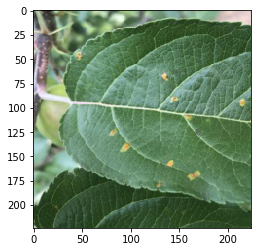

In [121]:
imshow(inputs)

In [122]:
test_input = inputs[None]

In [123]:
output = model_ft_cpu(test_input)


In [124]:
_, preds = torch.max(output, 1)

In [144]:
class_index = int(preds.numpy())

In [145]:
class_names[class_index]

'Apple___Cedar_apple_rust'

In [127]:
# class_names

In [139]:
# list(map(lambda x: " ".join(x.replace('_', ' ').split()), class_names))

In [150]:
torch.save(model_ft_cpu.state_dict(), 'plant-disease-model-cpu.pt')


In [152]:
loaded_model = torch.load('plant-disease-model-cpu.pt')


In [165]:
import pickle

In [173]:
# dump model object with pickle
pickle.dump(model_ft_cpu, open('plant-disease-model-cpu.pt','wb'))

pickle.dump(model_ft, open('plant-disease-model-gpu.pt','wb'))

In [169]:
model_new = pickle.load(open('plant-disease-model-cpu.pt','rb'))

In [170]:
out = model_new(test_input)

In [171]:
_, preds = torch.max(out, 1)

In [172]:
preds

tensor([2])